# MAPM: Microsoft Azure Predictive Maintenance

In [1]:
import os
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

## Overview of Raw Data

Error logs (hourly):
- encountered by the machines while in operating condition.
- don't shut down the machines, not considered as failures.


In [5]:
pd.read_csv('../datasets/MAPM/PdM_errors.csv.gz')

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4
...,...,...,...
3914,2015-11-21 08:00:00,100,error2
3915,2015-12-04 02:00:00,100,error1
3916,2015-12-08 06:00:00,100,error2
3917,2015-12-08 06:00:00,100,error3


In [6]:
pd.read_csv('../datasets/MAPM/PdM_failures.csv.gz')

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4
...,...,...,...
756,2015-11-29 06:00:00,99,comp3
757,2015-12-14 06:00:00,99,comp4
758,2015-02-12 06:00:00,100,comp1
759,2015-09-10 06:00:00,100,comp1


In [7]:
pd.read_csv('../datasets/MAPM/PdM_machines.csv.gz')

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2
...,...,...,...
95,96,model2,10
96,97,model2,14
97,98,model2,20
98,99,model1,14


In [8]:
pd.read_csv('../datasets/MAPM/PdM_maint.csv.gz')

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4
...,...,...,...
3281,2015-10-10 06:00:00,100,comp3
3282,2015-10-25 06:00:00,100,comp4
3283,2015-11-09 06:00:00,100,comp4
3284,2015-12-09 06:00:00,100,comp2


Telemetry Time Series Data:  
- Hourly average of voltage, rotation, pressure, vibration
- Collected from 100 machines for the year 2015

In [9]:
pd.read_csv('../datasets/MAPM/PdM_telemetry.csv.gz')

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511
...,...,...,...,...,...,...
876095,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941
876096,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072
876097,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561
876098,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259


In [80]:
def get_sequence_and_events(machine_id=1, error_id=None, comp_id=None,
                             start_date=None, end_date=None):

    sensors = pd.read_csv('../datasets/MAPM/PdM_telemetry.csv.gz')
    sensors = sensors[sensors.machineID == machine_id].reset_index(drop=True)
    # print(sensors.shape)
    errors = pd.read_csv('../datasets/MAPM/PdM_errors.csv.gz')
    errors = errors[errors.machineID == machine_id].reset_index(drop=True)
    # print(errors.shape)
    failures = pd.read_csv('../datasets/MAPM/PdM_failures.csv.gz')
    failures = failures[failures.machineID == machine_id]
    # print(failures.shape)
    data = sensors.merge(errors, how='left', on='datetime').merge(
        failures, how='left', on='datetime')

    data.datetime = pd.to_datetime(data.datetime)
    data = data.set_index('datetime')

    if start_date is not None:
        data = data[start_date:]
    if end_date is not None:
        data = data[:end_date]

    return data

In [85]:
def plot_sequence_and_events(data, machine_id=1):

    data = data[data.machineID == machine_id]
    fig, ax = plt.subplots(4 + 2, figsize=(8, 8))

    data.plot(y='volt', legend=True, ax=ax[0])
    data.plot(y='rotate', legend=True, ax=ax[1])
    data.plot(y='pressure', legend=True, ax=ax[2])
    data.plot(y='vibration', legend=True, ax=ax[3])

    if data.errorID.isnull().sum() < data.errorID.shape[0]:
        pd.get_dummies(data.errorID).plot(ax=ax[4])
    if data.failure.isnull().sum() < data.failure.shape[0]:
        pd.get_dummies(data.failure).plot(ax=ax[5])

    ax[0].set_title('Machine #{}'.format(machine_id))

    for i in range(5):
        ax[i].set_xlabel(None)
        ax[i].set_xticklabels([])

    fig.tight_layout()

    return fig, ax

In [90]:
def gen_summary(outdir='../out/'):
    os.makedirs(outdir, exist_ok=True)
    df = load_data('../datasets/mapm/')
    with PdfPages(outdir + '/mapm_summary.pdf') as pp:
        for i in tqdm.trange(1, 101):
            fig, _ = plot_sequence_and_events(df, machine_id=i)
            fig.savefig(pp, format='pdf')
            plt.clf()
            plt.close()


In [91]:
gen_summary()

100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


(<Figure size 720x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'Machine #1'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='datetime'>], dtype=object))

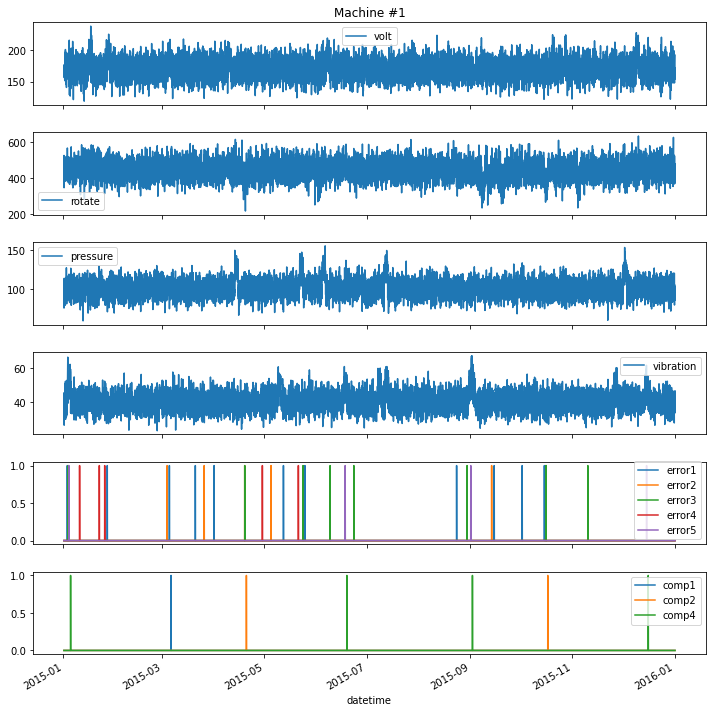

In [11]:
# Plot for a single machine
plot_sequence_and_events()

## Dataset Making

In [39]:
def load_data(fp):
    # Sensor data
    data = pd.read_csv(fp + '/PdM_telemetry.csv.gz')

    # Error alarm logs
    data = data.merge(
        pd.read_csv(fp + '/PdM_errors.csv.gz'),
        how='left', on=['datetime', 'machineID'])

    # Failure logs
    data = data.merge(
        pd.read_csv(fp + '/PdM_failures.csv.gz'),
        how='left', on=['datetime', 'machineID'])
    
    # Formatting
    data.datetime = pd.to_datetime(data.datetime)

    return data

In [77]:
def cleaning(df):

    # NaN values are encoded to -1
    df = df.sort_values('errorID')
    df.errorID = df.errorID.factorize()[0]
    df = df.sort_values('failure')
    df.failure = df.failure.factorize()[0]
    df = df.sort_values(['machineID', 'datetime'])

    df.errorID = df.errorID.astype('category')
    df.failure = df.failure.astype('category')

    df.volt = df.volt.astype('float32')
    df.rotate = df.rotate.astype('float32')
    df.pressure = df.pressure.astype('float32')
    df.vibration = df.vibration.astype('float32')

    df.datetime = pd.to_datetime(df.datetime)
    return df

In [78]:
df = load_data('../datasets/mapm/')
df = cleaning(df)
# df.errorID = df.errorID.sort_values().factorize()[0]
# df.failure = df.failure.sort_values().factorize()[0]
# df = df.sort_values(['machineID', 'datetime'])

In [79]:
df.dtypes

datetime     datetime64[ns]
machineID             int64
volt                float32
rotate              float32
pressure            float32
vibration           float32
errorID            category
failure            category
dtype: object

In [56]:
df = load_data('../datasets/mapm/')
df = df.sort_values('errorID')
df.errorID = df.errorID.factorize()[0]
df = df.sort_values('failure')
df.failure = df.failure.factorize()[0]
df = df.sort_values(['machineID', 'datetime'])

In [57]:
df

,datetime,machineID,volt,rotate,pressure,vibration,errorID,failure
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,-1,-1
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,-1,-1
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,-1,-1
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,-1,-1
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,-1,-1
...,...,...,...,...,...,...,...,...
876440,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,-1,-1
876441,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,-1,-1
876442,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,-1,-1
876443,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,-1,-1


In [37]:
df_m = [g for _, g in df.groupby('machineID')]
df_m[1]

,datetime,machineID,volt,rotate,pressure,vibration,errorID,failure
8763,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,-1,NaN
8764,2015-01-01 07:00:00,2,158.282044,432.372960,110.907806,37.267114,-1,NaN
8765,2015-01-01 08:00:00,2,168.242028,454.629639,97.877007,39.709461,-1,NaN
8766,2015-01-01 09:00:00,2,180.280316,438.391022,84.440430,40.490443,-1,NaN
8767,2015-01-01 10:00:00,2,169.719531,473.055664,110.395683,41.229578,-1,NaN
...,...,...,...,...,...,...,...,...
17524,2016-01-01 02:00:00,2,184.450454,417.062339,86.021068,40.792375,-1,NaN
17525,2016-01-01 03:00:00,2,167.267059,479.380172,101.744819,39.156569,-1,NaN
17526,2016-01-01 04:00:00,2,169.047260,470.612496,85.709946,34.862975,-1,NaN
17527,2016-01-01 05:00:00,2,178.900281,493.760668,93.547606,51.932874,-1,NaN


## Preprocessing